# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow
!pip install matplotlib
!pip install scikit-image

以下のsolution関数のみ編集してください。

In [3]:
def show_img(image):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def solution_random(x_test_df, train_df):
    # こちらの関数の中身を編集してください。
    import random
    from skimage.transform import radon

    waferMaps = train_df['waferMap']
    show_img(waferMaps[0])
    show_img(radon(waferMaps[0], theta=[0,90]))
    
    failure_types = list(train_df['failureType'].unique())
    num_rows = len(x_test_df)
    while len(failure_types) < num_rows:
        failure_types.append(random.choice(failure_types))

    return pd.DataFrame({'failureType': failure_types}, index=x_test_df.index)

In [4]:
def serch_area(map, y_start, x_start):
    stack = [(y_start, x_start),]
    (map_y,map_x) = map.shape   
    area_set = set()
    while len(stack) > 0:
        y, x = stack.pop()
        area_set.add((y, x))
        map[y,x] = 42
        if y > 0 and map[y - 1, x] == 2:
            stack.append((y - 1, x))
        if x > 0 and map[y, x - 1] == 2:
            stack.append((y, x - 1))
        if x + 1 < map_x and map[y, x + 1] == 2:
            stack.append((y, x + 1))
        if y + 1 < map_y and map[y + 1, x] == 2:
            stack.append((y + 1, x))
        if y > 0 and x > 0 and map[y - 1, x -1] == 2:
            stack.append((y - 1, x -1))
        if y + 1 < map_y and x > 0 and map[y + 1, x - 1] == 2:
            stack.append((y + 1, x - 1))
        if y > 0 and x + 1 < map_x and map[y - 1, x + 1] == 2:
            stack.append((y - 1, x + 1))
        if y + 1 < map_y and x + 1 < map_x and map[y + 1, x + 1] == 2:
            stack.append((y + 1, x + 1))
    area = len(area_set)
    upper_left = [y_start, x_start]
    lower_right = [y_start, x_start]
    center_y = 0.
    center_x = 0.
    edge_len = 0
    out_len = 0
    for y,x in area_set:
        if y < upper_left[0]:
            upper_left[0] = y
        if x < upper_left[1]:
            upper_left[1] = x
        if y > lower_right[0]:
            lower_right[0] = y
        if x > lower_right[1]:
            lower_right[1] = x

        center_y += ((y / map_y) - 0.5) / area
        center_x += ((x / map_x) - 0.5) / area
        
        if (y > 0 and (map[y - 1, x] == 0 or map[y - 1, x] == 1))\
        or (x > 0 and (map[y, x - 1] == 0 or map[y, x - 1] == 1))\
        or (x + 1 < map_x and (map[y, x + 1] == 0 or map[y, x + 1] == 1))\
        or (y + 1 < map_y and (map[y + 1, x] == 0 or map[y + 1, x] == 1)):
            edge_len += 1
            if (y > 0 and map[y - 1, x] == 0)\
            or (x > 0 and map[y, x - 1] == 0)\
            or (x + 1 < map_x and map[y, x + 1] == 0)\
            or (y + 1 < map_y and map[y + 1, x] == 0):
                out_len += 1

    len_y = lower_right[0] - upper_left[0] + 1
    len_x = lower_right[1] - upper_left[1] + 1
    density = area / (len_y * len_x)
    range = (len_y * len_x * np.pi) / (map_y * map_x)
    out_len /= edge_len
    edge_len /= np.sqrt(map_y * map_x)
    area /= map_y * map_x
    center = np.sqrt(center_y * center_y + center_x * center_x)
    return (area, density, range , center, edge_len, out_len)

def take_statistics(map):
    map_copy = map.copy()
    (map_y,map_x) = map_copy.shape
    light_num = 0
    space_num = 0
    max_area_info = (0.,0.,0.,0.,0.,0.,0.)
    out_len = 0.
    center_y = 0.
    center_x = 0.
    center_range_y = 0.
    center_range_x = 0.
    _sqrt = 1 / np.sqrt(map_y * map_x)
    for y in range(map_y):
        for x in range(map_x):
            space_num += 1
            if map[y, x] == 2:
                light_num += 1
                if (y > 0 and map[y - 1, x] == 0)\
                or (x > 0 and map[y, x - 1] == 0)\
                or (x + 1 < map_x and map[y, x + 1] == 0)\
                or (y + 1 < map_y and map[y + 1, x] == 0):
                    out_len += _sqrt

                center_y += np.abs((y / map_y) - 0.5)
                center_x += np.abs((x / map_x) - 0.5)
                center_range_y += np.abs(np.abs((y / map_y) - 0.5) - 0.25)
                center_range_x += np.abs(np.abs((x / map_x) - 0.5) - 0.25)

                if map_copy[y, x] == 2:
                    area_info = serch_area(map_copy, y, x)
                    area, *_ = area_info
                    if max_area_info[0] < area:
                        max_area_info = area_info
    light_per_space = light_num / space_num
    map_size = map_y * map_y / 10000
    center_y /= light_num
    center_x /= light_num
    center = np.sqrt(center_range_y * center_range_y + center_range_x * center_range_x)
    center_range_y /= light_num
    center_range_x /= light_num
    center_range = np.sqrt(center_range_y * center_range_y + center_range_x * center_range_x)
    return [light_per_space, map_size, out_len, center, center_range, *max_area_info]

In [5]:
def mirroring_map(map):
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    nwe_map = map.copy()
    # 他の位置に置換
    nwe_map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(nwe_map == 0)
    # 0の値を置換
    nwe_map[y_indices, x_indices] = 1
    return nwe_map - 1.0

def padding_map(map):
    nwe_map = map.copy() 
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 1)
    # 他の位置に置換
    nwe_map[y_indices, x_indices] = 0
    return nwe_map

def radon_normalize(map, theta=[0,90], resize_shape=(256, 256)):
    from skimage.transform import radon
    from PIL import Image
    import numpy as np

    resize_map = np.array(Image.fromarray(map).resize(resize_shape, Image.LANCZOS))
    return radon(resize_map, theta=theta)

def preprocess_statistics(wafer_map):
    return np.array([take_statistics(x) for x in wafer_map])


def preprocess_radon(wafer_map):
    data = np.rot90(np.array([radon_normalize(padding_map(x)) for x in wafer_map]), k=1, axes=(1, 2))
    # 1. x軸の逆転
    buff = np.array([[x[0][::-1],x[1]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    # 2. y軸の逆転
    buff = np.array([[x[0],x[1][::-1]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    # 3. xy軸の逆転
    buff = np.array([[x[1],x[0]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    return data


def preprocess_map(wafer_map):
    from PIL import Image

    # データの正規化
    train_maps = np.array([np.array(Image.fromarray(mirroring_map(x)).resize((32, 32), Image.LANCZOS)) for x in wafer_map])

    # 1. 画像を水平方向に反転
    flipped_horizontally = np.flip(train_maps, axis=2)
    train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # 2. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps

def cnn_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        # 畳み込みブロック1
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same', input_shape=(input_shape)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # 畳み込みブロック2
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # 畳み込みブロック3
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # ブロック4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),

        # 出力層
        tf.keras.layers.Dense(num_classes),
    ])

    return model

def dl_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),        
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])

    return model

def symple_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(14, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])
    return model

def symple_model2(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(9, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])
    return model

def calculate_class_weights(train_labels):
    from sklearn.utils.class_weight import compute_class_weight
    # クラスの重みを計算
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(train_labels), 
                                         y=train_labels)
    # クラスの重みを辞書型に変換
    return dict(enumerate(class_weights))

def solution_statistics(x_test_df, train_df):
    import tensorflow as tf
    failure_types = list(train_df['failureType'].unique())

    # 前処理
    test_maps = preprocess_statistics(x_test_df['waferMap'])
    print(test_maps.shape)
    train_statistics = preprocess_statistics(train_df['waferMap'])
    print(train_statistics.shape)
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']])

    # モデルの作成
    model = symple_model2(train_statistics[0].shape, len(failure_types))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    #学習
    model.fit(train_statistics, train_labels, epochs=8)
    
    # 予測
    logits = model.predict(test_maps)
    predictions = tf.nn.softmax(logits).numpy()
    answer = [failure_types[x.argmax()] for x in predictions]

    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)


def solution(x_test_df, train_df):
    import tensorflow as tf
    failure_types = list(train_df['failureType'].unique())

    train_L1_df, train_L2_df = train_test_split(train_df, stratify=train_df['failureType'], test_size=0.20, random_state=0)

    # 前処理
    test_maps = preprocess_map(x_test_df['waferMap'])
    train_L1_maps = preprocess_map(train_L1_df['waferMap'])
    train_L2_maps = preprocess_map(train_L2_df['waferMap'])
    train_full_maps = np.concatenate((train_L1_maps, train_L2_maps), axis=0)

    test_radon = preprocess_radon(x_test_df['waferMap'])
    train_L1_radon = preprocess_radon(train_L1_df['waferMap'])
    train_L2_radon = preprocess_radon(train_L2_df['waferMap'])
    train_full_radon = np.concatenate((train_L1_radon, train_L2_radon), axis=0)

    train_labels_L1 = np.array([failure_types.index(x) for x in train_L1_df['failureType']] * 8)
    train_labels_L2 = np.array([failure_types.index(x) for x in train_L2_df['failureType']] * 8)
    train_labels_full = np.concatenate((train_labels_L1, train_labels_L2), axis=0)


    # モデルの作成
    model_L1_cnn = cnn_model(train_L1_maps[0].shape, len(failure_types))
    model_L1_cnn.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model_L1_dl = dl_model(train_L1_radon[0].shape, len(failure_types))
    model_L1_dl.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model_L2 = symple_model((2,len(failure_types)), len(failure_types))
    model_L2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    #学習
    model_L1_cnn.fit(train_L1_maps, train_labels_L1, epochs=2)
    model_L1_dl.fit(train_L1_radon, train_labels_L1, epochs=1)

    logits_L1_cnn = model_L1_cnn.predict(train_L2_maps)
    logits_L1_dl = model_L1_dl.predict(train_L2_radon)
    train_L2 = np.array([ [cnn, dl] for cnn, dl in zip(tf.nn.softmax(logits_L1_cnn).numpy(), tf.nn.softmax(logits_L1_dl).numpy())])
    model_L2.fit(train_L2, train_labels_L2, epochs=12)
    
    model_L1_cnn.fit(train_full_maps, train_labels_full, epochs=4)
    model_L1_dl.fit(train_full_radon, train_labels_full, epochs=4)

    test_len = len(x_test_df['waferMap'])
    # 予測
    logits_cnn = model_L1_cnn.predict(test_maps)
    logits_dl = model_L1_dl.predict(test_radon)
    test_pre = np.array([ [cnn, dl] for cnn, dl in zip(tf.nn.softmax(logits_cnn).numpy(), tf.nn.softmax(logits_dl).numpy())])
    logits = model_L2.predict(test_pre)
    test_logits = np.zeros(test_len * len(failure_types), dtype=np.float64).reshape((test_len,len(failure_types)))
    for n in range(8):
        test_logits += logits[test_len*n:test_len*(n + 1)] / 8
    predictions = tf.nn.softmax(test_logits).numpy()
    answer = [failure_types[x.argmax()] for x in predictions]

    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)


solution関数は以下のように活用され、平均精度を計算します。

(2552, 11)
(22967, 11)
Epoch 1/8
718/718 [==============================] - 1s 514us/step - loss: 2.5419 - accuracy: 0.5059
Epoch 2/8
718/718 [==============================] - 0s 501us/step - loss: 1.0710 - accuracy: 0.6639
Epoch 3/8
718/718 [==============================] - 0s 481us/step - loss: 0.8846 - accuracy: 0.7494
Epoch 4/8
718/718 [==============================] - 0s 479us/step - loss: 0.7581 - accuracy: 0.7743
Epoch 5/8
718/718 [==============================] - 0s 480us/step - loss: 0.6714 - accuracy: 0.7908
Epoch 6/8
718/718 [==============================] - 0s 476us/step - loss: 0.6111 - accuracy: 0.8048
Epoch 7/8
718/718 [==============================] - 0s 474us/step - loss: 0.5713 - accuracy: 0.8133
Epoch 8/8
80/80 [==============================] - 0s 408us/step
平均精度：57.70%


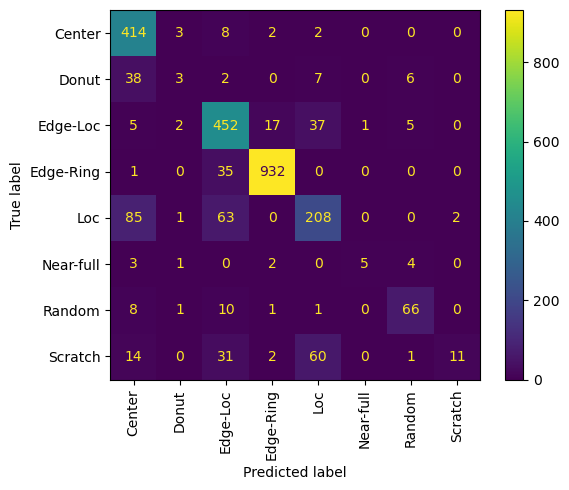

誤分類されたデータ:
                                                waferMap  dieSize   lotName  \
22529  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...   1109.0  lot45579   
5473   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1930.0  lot12352   
18473  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...    844.0  lot42232   
13214  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1080.0  lot23498   
21506  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1421.0  lot44807   
...                                                  ...      ...       ...   
19244  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...   1135.0  lot42759   
4528   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1291.0  lot10942   
22852  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...    904.0  lot45634   
17671  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    776.0  lot40792   
24682  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...    562.0  lot47044   

       waferIndex failureType  
22529   

In [6]:
%%timeit -r 1 -n 1

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution_statistics(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

# Confusion Matrixを計算
cm = confusion_matrix(y_test_df, user_result_df, labels=df['failureType'].unique())

# Confusion Matrixを可視化
ConfusionMatrixDisplay.from_predictions(y_test_df, user_result_df, xticks_rotation="vertical")
plt.show()

# 誤分類されたデータの抽出
misclassified_indices = y_test_df.index[y_test_df['failureType'] != user_result_df['failureType']]
misclassified_data = test_df.loc[misclassified_indices]

# 誤分類されたデータを表示
print("誤分類されたデータ:")
print(misclassified_data)
#for map in misclassified_data['waferMap']:
#    print(map.shape)
#    show_img(map)

